An attempt at solving a Deep learning problem

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python

# modules required for the learning task
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os # for environment related stuff.
import scipy

# for visualization stuff
import matplotlib.pyplot as plt
import seaborn as sns

# keras modules required for this notebook
# Starting architecture
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.layers import Flatten, Dense, Dropout
from keras.optimizers import SGD


%matplotlib inline

# for checking the os files related stuff (executing shell commands)
from subprocess import check_output

Using TensorFlow backend.


In [2]:
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

# constant path to the data source
path = "../Data"

def exec_command(cmd):
    '''
        function to execute a shell command and see it's 
        output in the python console
        @params
        cmd = the command to be executed along with the arguments
              ex: ['ls', '../input']
    '''
    print(check_output(cmd).decode("utf8"))

In [3]:
# check the files in the data source environment:
exec_command(["ls", path])

train
train_labels.csv



In [4]:
# check the structure of the train_labels.csv file
exec_command(['head', '-10', os.path.join(path, 'train_labels.csv')])

name,invasive
1,0
2,0
3,1
4,0
5,1
6,0
7,1
8,1
9,0



In [5]:
# load the labels from the csv dataset
labels_path = os.path.join(path, "train_labels.csv")
labels = pd.read_csv(labels_path).values

# check the shape of the labels....
# I am in love with the shape of you... ooo...o 
labels.shape

(2295, 2)

No. of positive examples: 1448
No. of negative examples: 847


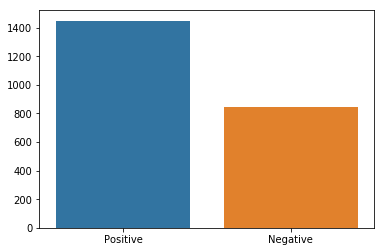

In [6]:
# check the skewness in the data. (No of positive examples and No. of negative examples)
pos_count = (labels[:, 1] == 1).sum()
neg_count = (labels[:, 1] == 0).sum()

print("No. of positive examples: %d" %pos_count)
print("No. of negative examples: %d" %neg_count)

# plot a bar chart for better view into the dataset
x_axis = ['Positive', 'Negative']
y_axis = [pos_count, neg_count]
sns.barplot(x_axis, y_axis); # semicolon to supress the output

#Alright! So, there are only half as many negative examples as the positive examples in the original complete dataset.
##Now we partition the dataset into train and cross validation datasets.

In [7]:
# shuffle the labels in the dataset:
np.random.shuffle(labels)

partition = int(labels.shape[0] * 0.70)
train_set = labels[:partition, :]
cv_set = labels[partition: , :]

print("Train Partition: %s" %str(train_set.shape))
print("cross Validation Partition: %s" %str(cv_set.shape))

Train Partition: (1606, 2)
cross Validation Partition: (689, 2)


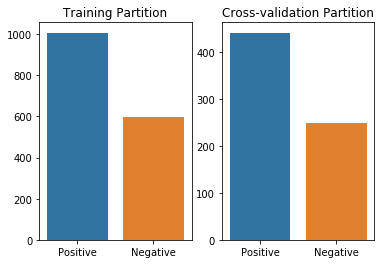

In [8]:
# now check the positive and negative distribution in the train and cross validation datatsets
p_train = (train_set[:, 1] == 1).sum()
n_train = (train_set[:, 1] == 0).sum()

p_cv = (cv_set[:, 1] == 1).sum()
n_cv = (cv_set[:, 1] == 0).sum()

fig, axs = plt.subplots(ncols=2)

# plot a bar chart for better view into the dataset
axs[0].set_title("Training Partition")
x_axis = ['Positive', 'Negative']
y_axis = [p_train, n_train]
sns.barplot(x_axis, y_axis, ax=axs[0]); # semicolon to supress the output

axs[1].set_title("Cross-validation Partition")
x_axis = ['Positive', 'Negative']
y_axis = [p_cv, n_cv]
sns.barplot(x_axis, y_axis, ax=axs[1]); # semicolon to supress the output

##Since the data was randomly shuffled before partitioning, it can be observed that the data elements skew has been preserved in the two partitions.

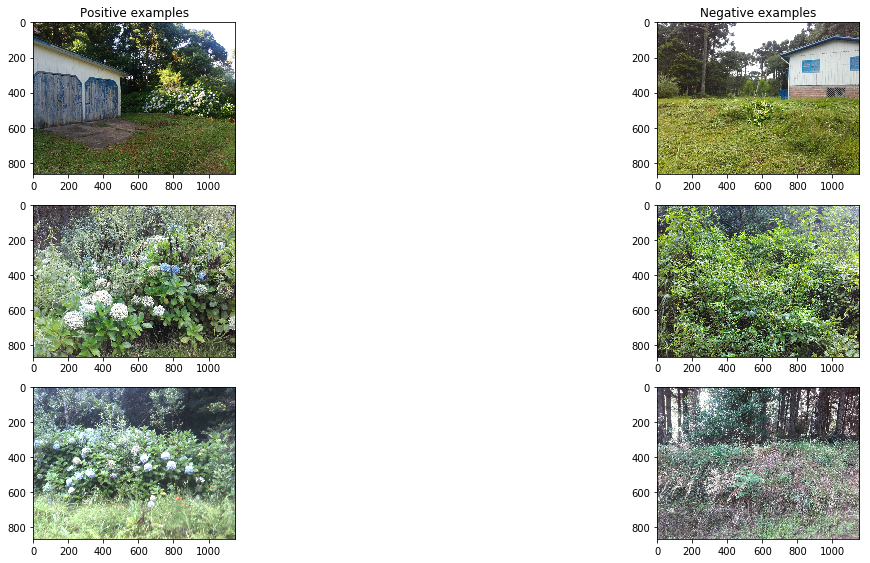

In [11]:
# visualize a few images from the training set for the positive and negative labels
pos = (train_set[train_set[:, 1] == 1, :])
neg = (train_set[train_set[:, 1] == 0, :])

# randomly pick three images from the pos set and three images from the neg set
pos_images = pos[np.random.randint(pos.shape[0], size=3), 0]
neg_images = neg[np.random.randint(neg.shape[0], size=3), 0]

# display the pos_images:
images = zip(pos_images, neg_images)

fig, axs = plt.subplots(ncols=2, nrows=3)
fig.set_size_inches(20.5, 9.5)

axs[0, 0].set_title("Positive examples")
axs[0, 1].set_title("Negative examples")

i = 0
for (pos_image, neg_image) in images:
    pos_img_path = os.path.join(path, "train", str(pos_image) + ".jpg")
    neg_img_path = os.path.join(path, "train", str(neg_image) + ".jpg")
    p_image = scipy.ndimage.imread(pos_img_path)
    n_image = scipy.ndimage.imread(neg_img_path)
    axs[i, 0].imshow(p_image); axs[i, 1].imshow(n_image)
    i += 1

shape of the input images: (100, 100, 3)


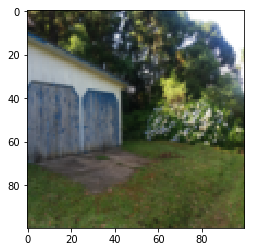

In [12]:
# check how large are the images and resize them to a standard size.
test_image = scipy.misc.imresize(scipy.ndimage.imread(os.path.join(path, "train", str(pos_images[0]) + ".jpg")), 
                                 [100, 100, 3])
plt.imshow(test_image)
print("shape of the input images: %s" %str(test_image.shape))

##OK! Enough of analysis now. Let's try building a ConvNet on this data

In [13]:
# function to load and provide batches of input images
def generate_batch(start, size, source):
    '''
        TO load the size number of images into kernel memory and return this data sturcture
        @Params
        start = the start index for batch generation
        size = number of images in the batch 
    '''
    data = np.ndarray([size, 100, 100, 3], dtype=float) # array for the images
    labels = np.empty([size], dtype=float) # array for the labels
    
    max_value = 255 # the max value of any pixel
    
    # traverse the train set to load the images:
    count = 0 # start the counter from 0
    for i in range(start, min(len(source), start + size)):
        data[count] = scipy.misc.imresize(scipy.ndimage.imread(os.path.join(path, "train", 
                         str(source[i, 0]) + ".jpg")), [100, 100, 3])
        #data[count] /= max_value # range normalize the pixel values
        labels[count] = source[i, 1]
        count += 1 # increment the counter
    
    # load the remaining images by rollover from the source
    for i in range(0, (start + size) - len(source)):
        data[count] = scipy.misc.imresize(scipy.ndimage.imread(os.path.join(path, "train", 
                         str(source[i, 0]) + ".jpg")), [100, 100, 3])
        #data[count] /= max_value # range normalize the pixel values
        labels[count] = source[i, 1]
        count += 1 # increment the counter

    return data, labels

In [14]:
# test the method defined above
# current_data, current_labels = generate_batch(1600, 100) # checking the rollover case
# print(current_data.shape)
# print(current_data[3:6], current_labels[3:6]) # check the data inside a random few images
# alright! so the data batches are getting generated quite properly.
# test successful. So, now don't run this again since kernel memory is limited

#So, I have not yet figured out if range normalizing the pixel values will be helpful or not. For now I am not range normalizing them.

Let's create a Keras ConvNet model to test.

In [15]:
def ConvBlock(model, layers, filters):
    for i in range(layers):
        model.add(ZeroPadding2D((1, 1)))
        model.add(Convolution2D(filters, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

In [16]:
def FCBlock(model):
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    
def input_shape_definer(x):
    # just an identity function to specify the input shape of the model
    return x

In [17]:
# model for solving the problem.

from keras.models import Sequential, Model, load_model
from keras import applications
from keras import optimizers
from keras.layers import Dropout, Flatten, Dense
from keras.layers.core import Lambda

img_rows, img_cols, img_channel = 100, 100, 3

model = Sequential()
model.add(Lambda(input_shape_definer, input_shape=(100, 100, 3), output_shape=(100, 100, 3)))

# model for computation:
ConvBlock(model, 2, 64)
ConvBlock(model, 2, 128)
ConvBlock(model, 3, 256)
ConvBlock(model, 3, 512)
ConvBlock(model, 3, 512)

model.add(Flatten())
FCBlock(model)
FCBlock(model)
model.add(Dense(1, activation='sigmoid'))

In [18]:
# a detailed description of the model to be used
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 100, 100, 3)       0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 102, 102, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 100, 64)      1792      
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 102, 102, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 100, 100, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 50, 64)        0         
_________________________________________________________________
zero_padding2d_3 (ZeroPaddin (None, 52, 52, 64)        0         
__________

#lets start training the model:

In [19]:
from keras.utils.data_utils import get_file

# load the pretrained VGGNet weights from the url mentioned:
model.load_weights(get_file('vgg16.h5', 'http://www.platform.ai/models/vgg16.h5', cache_subdir='models'))

 - 0s
 - 0s
 - 0s
 - 0s


ImportError: `load_weights` requires h5py.

In [40]:
model.compile(optimizer='Adam',
                loss='categorical_crossentropy', metrics=['accuracy'])

# train the model so that it sees every element in the dataset once:
batch_size = 200
total_dataset_size = len(train_set)

saved_path = "./Model2"

if(os.path.isfile(saved_path)):
    model.load_weights(saved_path)

# let's go over the first 1000 images in the dataset
count = 0  #start the count to 0
for i in range(0, 15):
    print("count: " + str(i))
    x_train, y_train = generate_batch(count, batch_size, train_set)
    model.fit(x_train, y_train, epochs=2, batch_size=100); # suppress the print output.
    count = (count + batch_size) % total_dataset_size
    
# save the weights to the filesystem
model.save_weights(saved_path)

In [ ]:
# extract the cross_validation images from the dataset
x_eval, y_eval = generate_batch(0, 100, cv_set)

evaluation = model.evaluate(x_eval, y_eval)
acc = evaluation[1]
print('Evaluation accuracy:{0}'.format(round(acc, 4)))
print(evaluation)

In [ ]:
layer_dict = dict([(layer.name, layer) for layer in model.layers])
print(layer_dict)

In [ ]:
from keras import backend as K

def iterate_function_generator(layer_name, filter_index):
    input_img  = model.input

    # build a loss function that maximizes the activation
    # of the nth filter of the layer considered
    layer_output = layer_dict[layer_name].output
    loss = K.mean(layer_output[:, :, :, filter_index])

    # compute the gradient of the input picture wrt this loss
    grads = K.gradients(loss, input_img)[0]


    # normalization trick: we normalize the gradient
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

    # this function returns the loss and grads given the input picture
    iterate = K.function([input_img], [loss, grads])
    return iterate

In [ ]:
import numpy as np

def generate_visualizations(layer_name):
    # find out how many filters are present:
    #size = layer_dict[layer_name].output.shape[3]
    
    size = 5 # for now we only look at the first 5 filters in that layer
    
    # create a list of empty images
    vizs = np.ndarray([size, 1, 100, 100, 3])
    # create the visualization arrays
    for i in range(size):
        # we start from a gray image with some noise
        vizs[i] = np.random.random((100, 100, 3)) * 20 + 128.
       
    print(vizs.shape)
        
    # set the step size for the gradient ascent
    step = 1

    for filter_index in range(size):
        for i in range(20):
            loss_value, grads_value = iterate_function_generator(layer_name, filter_index)([vizs[filter_index]])
            vizs[filter_index] += grads_value * step
        print("current filter: " + str(filter_index + 1))            

    return vizs

In [ ]:
# generate the visualizations for the layer number 1 (conv 2d)
layer1_conv_vis = generate_visualizations(model.layers[1].name)

In [ ]:
print(layer1_conv_vis[3, 0, :5, :5, 0])

In [ ]:
fig, axs = plt.subplots(ncols= 2, nrows = 2)
fig.set_size_inches(30, 30)
for i in range(2):
    for j in range(2):
        axs[i, j].imshow(layer1_conv_vis[(i * 2) + j][0]);

I require help on how to train the small model that I have constructed here and exactly what might be the problem that is causing this underfitting of the model. Would training for more time help? Suggestions are most welcome.